### Basic Classes
Definition of basic classes required for the solution of the multi-armed bandit problem. Inspiration and code used from https://github.com/bgalbraith/bandits. The problem explanation can be better follwed in the chapter 2 of the book _“Reinforcement Learning, An Introduction”_ by Sutton and Barto  

In [47]:
# Inspired by https://github.com/bgalbraith/bandits
# Some part of the code were taken from this repository 
# and modified according to requirements of the current project.
# License of the project adjusted to be compliant with the used source.

import numpy as np

class MultiArmedBandit(object):
    """
    A Multi-armed Bandit
    """
    def __init__(self, k):
        self.k = k
        self.action_values = np.zeros(k)
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = 0

    def pull(self, action):
        return 0, True
    
class MultiArmedBanditt(object):
    """
    A Multi-armed Bandit
    """
    def __init__(self, arms):
        self.arms = arms
        self.action_values = np.zeros(len(arms))
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(len(self.arms))
        self.optimal = 0

    def pull(self, action):
        return 0, True

class Arm(object):
    """
    Representation of an arm to be used by a multiarmed bandit.
    By default this arm represent a random arm picking its values from a uniform distribution between 0 and 1.
    """
    def pull(self):
        return np.random.uniform();

class GaussianArm(Arm):
    """
    Representation of an arm using the values coming from a normal distribution
    """
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    def pull(self):
        return np.random.normal(self.mu, self.sigma)


class GaussianBandit(MultiArmedBandit):
    """
    Gaussian bandits model the reward of a given arm as normal distribution with
    provided mean and standard deviation.
    """
    def __init__(self, k, mu=0, sigma=1):
        super(GaussianBandit, self).__init__(k)
        self.mu = mu
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.action_values = np.random.normal(self.mu, self.sigma, self.k)
        self.optimal = np.argmax(self.action_values)

    def pull(self, action):
        return (np.random.normal(self.action_values[action]),
                action == self.optimal)

class Policy(object):
    """
    A policy prescribes an action to be taken based on the memory of an agent.
    """
    def __str__(self):
        return 'generic policy'

    def choose(self, agent):
        return 0


class EpsilonGreedyPolicy(Policy):
    """
    The Epsilon-Greedy policy will choose a random action with probability
    epsilon and take the best apparent approach with probability 1-epsilon. If
    multiple actions are tied for best choice, then a random action from that
    subset is selected.
    """
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, agent):
        if np.random.random() < self.epsilon:
            return np.random.choice(len(agent.value_estimates))
        else:
            action = np.argmax(agent.value_estimates)
            check = np.where(agent.value_estimates == action)[0]
            if len(check) == 0:
                return action
            else:
                return np.random.choice(check)

class RandomPolicy(EpsilonGreedyPolicy):
    """
    The Random policy randomly selects from all available actions with no
    consideration to which is apparently best. This can be seen as a special
    case of EpsilonGreedy where epsilon = 1 i.e. always explore.
    """
    def __init__(self):
        super(RandomPolicy, self).__init__(1)

    def __str__(self):
        return 'random'

class SoftmaxPolicy(Policy):
    """
    The Softmax policy converts the estimated arm rewards into probabilities
    then randomly samples from the resultant distribution. This policy is
    primarily employed by the Gradient Agent for learning relative preferences.
    """
    def __str__(self):
        return 'SM'

    def choose(self, agent):
        a = agent.value_estimates
        pi = np.exp(a) / np.sum(np.exp(a))
        cdf = np.cumsum(pi)
        s = np.random.random()
        return np.where(s < cdf)[0][0]
    
    
class Agent(object):
    """
    An Agent is able to take one of a set of actions at each time step. The
    action is chosen using a strategy based on the history of prior actions
    and outcome observations.
    """
    def __init__(self, bandit, policy, prior=0, gamma=None):
        self.policy = policy
        self.k = bandit.k
        self.prior = prior
        self.gamma = gamma
        self._value_estimates = prior*np.ones(self.k)
        self.action_attempts = np.zeros(self.k)
        self.t = 0
        self.last_action = None

    def __str__(self):
        return 'f/{}'.format(str(self.policy))

    def reset(self):
        """
        Resets the agent's memory to an initial state.
        """
        self._value_estimates[:] = self.prior
        self.action_attempts[:] = 0
        self.last_action = None
        self.t = 0

    def choose(self):
        action = self.policy.choose(self)
        self.last_action = action
        return action

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        if self.gamma is None:
            g = 1 / self.action_attempts[self.last_action]
        else:
            g = self.gamma
        q = self._value_estimates[self.last_action]

        self._value_estimates[self.last_action] += g*(reward - q)
        self.t += 1

    @property
    def value_estimates(self):
        return self._value_estimates

### Runner
Definition of the class in charge of running the experiment. Defines a condition to stop the experiment and creates an instance of the required elements to run the simulation. It also defines the number of one-armed bandits that will be used in the simulation. In order to obtain meaningful results, the simulator has to run several times each experiment, obtaining an average of the results to work with. Thus, a parameter for the number of experiments is required.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class Simulator(object):
    def __init__(self, bandit, agents, iterations, experiments):
        self.bandit = bandit
        self.agents = agents
        self.iterations = iterations
        self.experiments = experiments
    
    def reset(self):
        self.bandit.reset()
        for agent in self.agents:
            agent.reset()
    
    def run(self):
        self.scores = np.zeros((self.iterations, len(self.agents)))
        self.optimal = np.zeros_like(self.scores)
        
        for _ in range(self.experiments):
            for t in range(self.iterations):
                for i, agent in enumerate(self.agents):
                    action = agent.choose()
                    reward, is_optimal = self.bandit.pull(action)
                    agent.observe(reward)

                    self.scores[t, i] += reward
                    if is_optimal:
                        self.optimal[t, i] += 1
                
        self.scores = self.scores / self.experiments
        self.optimal = self.optimal / self.experiments
                
    def plot_agents_results(self):
        sns.set_style('white')
        sns.set_context('talk')
        plt.subplot(2, 1, 1)
        plt.title('Results')
        plt.plot(self.scores)
        plt.ylabel('Average Reward')
        plt.legend(self.agents, loc=4)
        plt.subplot(2, 1, 2)
        plt.plot(self.optimal * 100)
        plt.ylim(0, 100)
        plt.ylabel('% Optimal Action')
        plt.xlabel('Time Step')
        plt.legend(self.agents, loc=4)
        sns.despine()
        plt.show()

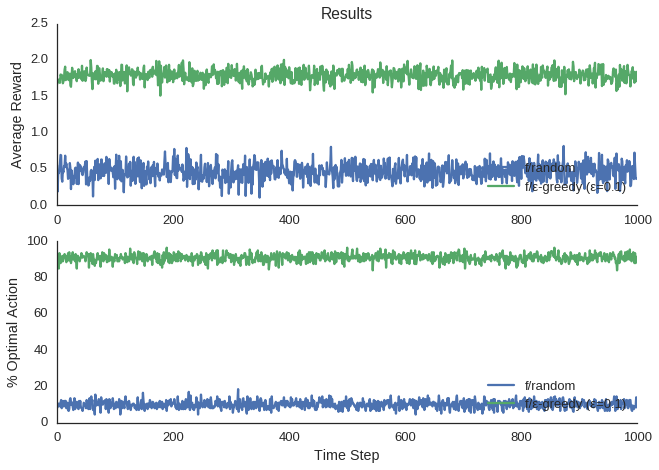

In [49]:
n_arms = 10
iterations = 1000
experiments = 200
bandit = GaussianBandit(n_arms)

agents = [
    Agent(bandit, RandomPolicy()),
    Agent(bandit, EpsilonGreedyPolicy(0.1)),
    #Agent(bandit, SoftmaxPolicy(0.1)),
]
simulator = Simulator(bandit, agents, iterations, experiments)
simulator.run()
simulator.plot_agents_results()
